# Library Installation

In [1]:
pip install -U wsq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.9/355.9 kB 6.5 MB/s eta 0:00:00


# Importing Libraries

In [2]:
import os
import sys
import struct
import wsq
import cv2

In [3]:
from wsq import WsqImagePlugin # Import the WsqImageFile class
from PIL import Image, ImageFile

# Making Converter Function (WSQ to BMP)

In [4]:
def create_bmp_header(width, height, bit_count, colors_used, pixels_per_meter_x, pixels_per_meter_y):
    """
    Create a BMP file header and DIB header based on the provided parameters.
    """
    # BMP file header (14 bytes)
    signature = b'BM'
    file_size = 1078 + (width * height)  # Offset (1078) + pixel data size
    reserved = 0
    offset = 1078  # Offset to pixel data

    # DIB header (BITMAPINFOHEADER, 40 bytes)
    dib_header_size = 40
    planes = 1
    compression = 0
    image_size = 0  # Can be 0 for uncompressed images
    important_colors = colors_used

    # Pack the BMP file header
    bmp_header = struct.pack(
        '<2sIII',  # Format: 2s (signature), I (file size), I (reserved), I (offset)
        signature, file_size, reserved, offset
    )

    # Pack the DIB header
    dib_header = struct.pack(
        '<IIIHHIIIIII',  # Format: I (header size), I (width), I (height), H (planes), H (bit count), I (compression), I (image size), I (x ppm), I (y ppm), I (colors used), I (important colors)
        dib_header_size, width, height, planes, bit_count,
        compression, image_size, pixels_per_meter_x, pixels_per_meter_y,
        colors_used, important_colors
    )

    return bmp_header + dib_header

In [5]:
def create_color_palette():
    """
    Create a default grayscale color palette (256 colors).
    """
    palette = []
    for i in range(256):
        palette.extend((i, i, i, 0))  # Blue, Green, Red, Reserved
    return bytes(palette)

In [6]:
def wsq_to_bmp(wsq_file_path, bmp_file_path):
    """
    Convert a WSQ file to BMP format, adhering to the specified BMP file structure.
    """
    try:
        # Open the WSQ image using the WsqImagePlugin.WsqImageFile class
        with open(wsq_file_path, 'rb') as wsq_file:
            wsq_image = WsqImagePlugin.WsqImageFile(wsq_file)
            wsq_image.load()  # Load the image data

            # Convert WSQ image to a PIL Image
            img = wsq_image.convert("L")  # Convert to grayscale

            # Get image dimensions
            width, height = img.size

            # Create BMP header and DIB header
            bit_count = 8  # 8-bit color depth
            colors_used = 256  # 256 colors in the palette
            pixels_per_meter_x = 3780  # From your BMP info
            pixels_per_meter_y = 3780  # From your BMP info
            bmp_header = create_bmp_header(width, height, bit_count, colors_used, pixels_per_meter_x, pixels_per_meter_y)

            # Create color palette
            palette = create_color_palette()

            # Save the BMP file
            with open(bmp_file_path, 'wb') as bmp_file:
                # Write BMP header and DIB header
                bmp_file.write(bmp_header)

                # Write color palette
                bmp_file.write(palette)

                # Write pixel data
                img_data = img.tobytes()
                bmp_file.write(img_data)

            print(f"WSQ image converted to BMP and saved as {bmp_file_path}")

    except Exception as e:
        print(f"Error: {e}")

In [7]:
input_wsq_file = "./sample_data/input_image.wsq"  # Replace with your WSQ file path
output_bmp_file = "./sample_data/output_image.BMP"  # Replace with your desired output BMP file path

# Check if the input WSQ file exists
if not os.path.exists(input_wsq_file):
    print(f"Error: The file {input_wsq_file} does not exist.")
else:
    # Perform the conversion
    wsq_to_bmp(input_wsq_file, output_bmp_file)

WSQ image converted to BMP and saved as ./sample_data/output_image.BMP


# Download the Dataset

Idea got from Youtube Link: https://www.youtube.com/watch?v=IIvfqfKkiio

For Dataset Visiting: https://www.kaggle.com/datasets/ruizgara/socofing

# Fingerprint Matching

In [8]:
sample = cv2.imread("./sample_data/output_image.BMP")

UNZIPPING THE FILE/FOLDER

In [9]:
path_to_zip_file = "./sample_data/Real.zip"
directory_to_extract_to = "./sample_data"

In [10]:
import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall(directory_to_extract_to)

# Fingerprint Match Algorithm

In [11]:
best_score = 0
filename = None
image = None
kp1, kp2, mp = None, None, None

#for file in [file for file in os.listdir("./sample_data/Real/") if file.endswith(".BMP")]:
for file in [file for file in os.listdir("./sample_data/Real/")]:
    fingerprint_image = cv2.imread("./sample_data/Real/"+file)
    sift = cv2.SIFT_create()

    keypoints_1, descriptors_1 = sift.detectAndCompute(sample, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(fingerprint_image, None)

    matches = cv2.FlannBasedMatcher({'algorithm': 1, 'trees': 10}, {}).knnMatch(descriptors_1, descriptors_2, k=2)

    good_matches = []
    for p, q in matches:
        if p.distance < 0.1 * q.distance:
            good_matches.append(p)

    keypoints = 0
    if len(keypoints_1) < len(keypoints_2):
        keypoints = len(keypoints_1)
    else:
        keypoints = len(keypoints_2)

    if len(good_matches) / keypoints * 100 > best_score:
        best_score = len(good_matches) / keypoints * 100
        filename = file
        image = fingerprint_image
        kp1, kp2, mp = keypoints_1, keypoints_2, good_matches

print(f"Best Score: {best_score}")
print(f"Filename: {filename}")


Best Score: 100.0
Filename: output_image_Real.BMP


In [12]:
result = cv2.drawMatches(sample, kp1, image, kp2, mp, None)
result = cv2.resize(result, None, fx=4, fy=4)

Below code for local machine not for colab

In [13]:
"""
cv2.imshow("result", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

"""

'\ncv2.imshow("result", result)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n\n'

In [14]:
from google.colab.patches import cv2_imshow

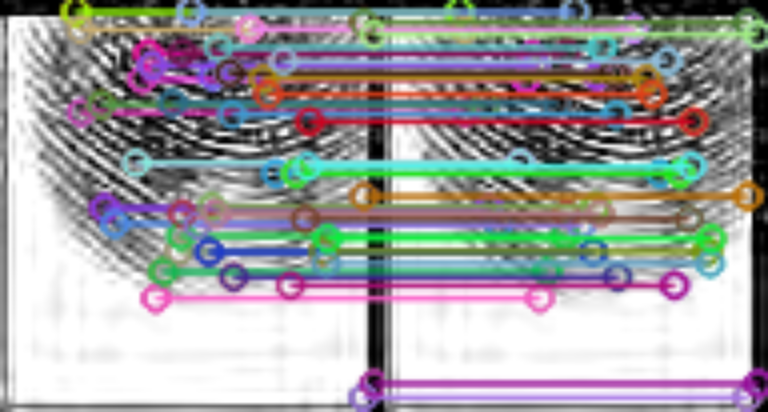

In [15]:
cv2_imshow(result)
cv2.waitKey(0)
cv2.destroyAllWindows()